In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
ls

README.md                               discrete_anomaly_detection.ipynb
continuous_probabilistic_methods.ipynb  env.py
curr_access.csv                         lemonade.csv
curriculum-access.txt                   time_series_anomaly_detection.ipynb


In [3]:
colnames=['date', 'time', 'request_url', 'user_id', 'cohort', 'ip']

df = pd.read_csv('curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"'
)

In [4]:
df.head()

,date,time,request_url,user_id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62


In [5]:
df.shape

(543595, 6)

In [6]:
df['timestamp'] = df[['date', 'time']].agg(' '.join, axis=1)

In [7]:
df.head()

,date,time,request_url,user_id,cohort,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62,2018-01-26 09:56:02
2,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,2018-01-26 09:56:06
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,2018-01-26 09:56:24
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62,2018-01-26 09:56:41


In [8]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp) 
df = df.set_index('timestamp')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543595 entries, 2018-01-26 09:55:03 to 2020-05-15 15:06:05
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         543595 non-null  object 
 1   time         543595 non-null  object 
 2   request_url  543594 non-null  object 
 3   user_id      543595 non-null  int64  
 4   cohort       515739 non-null  float64
 5   ip           543595 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 29.0+ MB


In [10]:
df.describe()

,user_id,cohort
count,543595.000000,515739.000000
mean,329.355049,32.625925
std,178.595241,12.699322
min,1.000000,1.000000
25%,195.000000,24.000000
50%,344.000000,29.000000
75%,476.000000,34.000000
max,650.000000,57.000000


In [11]:
df.isna().sum()

date               0
time               0
request_url        1
user_id            0
cohort         27856
ip                 0
dtype: int64

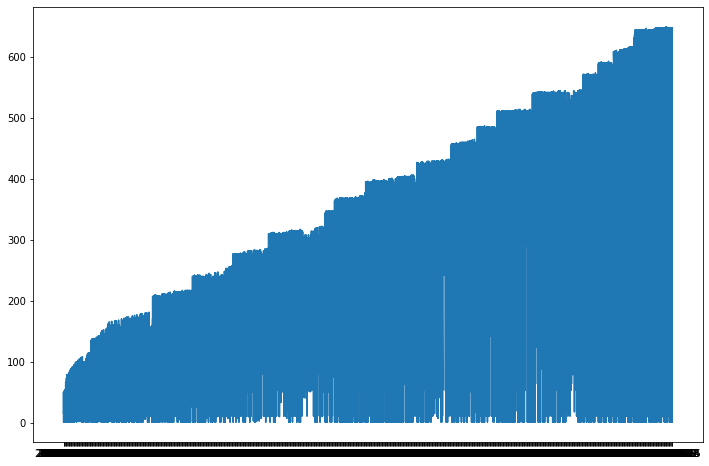

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df.date, df.user)
plt.show()

In [13]:
df.request_url.isna().sum()

1

In [14]:
df[df.user == 586].isna().sum()

date           0
time           0
request_url    1
user_id        0
cohort         0
ip             0
dtype: int64

In [15]:
# what is the index of the null request_url
df[df.request_url.isna()].user == 586

timestamp
2020-04-08 09:25:18    True
Name: user_id, dtype: bool

In [16]:
df.user_id.value_counts()

11     11065
64     10784
53      9534
1       5436
344     5370
       ...  
593        1
592        1
649        1
66         1
163        1
Name: user_id, Length: 650, dtype: int64

In [17]:
df.cohort.isna().sum()

27856

In [18]:
df.cohort.sort_values().value_counts()

33.0    38851
28.0    37409
29.0    36613
24.0    35336
53.0    29992
22.0    28997
23.0    28193
32.0    27920
26.0    27586
51.0    26389
52.0    26212
25.0    25364
31.0    24322
34.0    23845
27.0    20264
56.0    14438
55.0    14252
57.0     9547
14.0     9374
1.0      8882
21.0     7411
17.0     4821
13.0     2626
8.0      1711
18.0     1641
19.0     1165
16.0      743
15.0      691
7.0       495
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
5.0         1
Name: cohort, dtype: int64

In [19]:
df = df.fillna(20)

- Can you label students who are viewing both the web dev and data science curriculum? 

In [20]:
# function that takes in a url topic and returns a course name
def get_course(topic):
    if type(topic) != str:
        return "Unknown"
    # Recommend using boolean flag variables to simplify
    exists_in_web_dev = False
    exists_in_ds = False
    wd = ['javascript', 'java', 'css', 'mysql', 'jquery', 'spring', 'html', 'object_oriented_programming']
    ds = ['anomaly', 'timeseries', 'python', 'mysql', 'regression', 'classification', 'stats', 'tidy']
    for w in wd:
        if w in topic:
            exists_in_web_dev = True
    for d in ds:
        if d in topic:
            exists_in_ds = True
    if exists_in_ds and exists_in_web_dev:
        answer = "Both"
    elif exists_in_ds:
        answer = "Data Science"
    elif exists_in_web_dev:
        answer = "Web Dev"
    else:
        answer = "Unknown"
    return answer

In [21]:
df['course'] = df.request_url.apply(get_course)
df.head()

,date,time,request_url,user_id,cohort,ip,course
timestamp,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,98.106.20.62,Unknown
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62,Web Dev
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,Web Dev
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,Web Dev
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62,Web Dev


- Can you label students by the program they are in? 

In [22]:
# Data Science course visitors
df[df.course == 'Data Science'].sample(15)

,date,time,request_url,user_id,cohort,ip,course
timestamp,,,,,,,
2020-04-08 14:59:06,2020-04-08,14:59:06,6-regression/7-model,583,55.0,46.28.10.172,Data Science
2020-04-07 16:40:47,2020-04-07,16:40:47,6-regression/8.0-Project,583,55.0,46.28.10.172,Data Science
2020-01-16 08:34:00,2020-01-16,08:34:00,10-anomaly-detection/2-continuous-probabilisti...,473,34.0,98.106.20.59,Data Science
2020-03-05 11:11:13,2020-03-05,11:11:13,4-python/8.4.4-advanced-dataframes,581,55.0,98.106.20.59,Data Science
2020-04-13 16:39:32,2020-04-13,16:39:32,7-classification/3-prep,471,34.0,100.159.247.102,Data Science
2020-03-30 09:20:42,2020-03-30,09:20:42,5-stats/4.1-hypothesis-testing-overview,578,55.0,105.6.218.58,Data Science
2020-04-22 09:37:38,2020-04-22,09:37:38,7-classification/6.2-decision-trees,248,28.0,174.174.116.202,Data Science
2020-05-01 16:14:08,2020-05-01,16:14:08,6-regression/3-split-and-scale,616,55.0,71.115.10.242,Data Science
2019-11-25 07:49:06,2019-11-25,07:49:06,7-classification/3-prep,475,34.0,71.227.110.183,Data Science


In [23]:
df[df.course == 'Data Science']

,date,time,request_url,user_id,cohort,ip,course
timestamp,,,,,,,
2019-05-30 11:35:46,2019-05-30,11:35:46,python,11,28.0,98.106.20.59,Data Science
2019-07-02 08:52:32,2019-07-02,08:52:32,4-python/4-control-structures,1,28.0,98.106.20.59,Data Science
2019-07-02 08:52:36,2019-07-02,08:52:36,4-python/5-functions,1,28.0,98.106.20.59,Data Science
2019-07-02 09:05:49,2019-07-02,09:05:49,4-python/5-functions,1,28.0,98.106.20.59,Data Science
2019-07-02 09:07:13,2019-07-02,09:07:13,4-python/5-functions,1,28.0,98.106.20.59,Data Science
...,...,...,...,...,...,...,...
2020-05-15 14:52:13,2020-05-15,14:52:13,10-anomaly-detection/3-discrete-probabilistic-...,11,28.0,77.186.132.227,Data Science
2020-05-15 14:52:38,2020-05-15,14:52:38,10-anomaly-detection/2-continuous-probabilisti...,11,28.0,77.186.132.227,Data Science
2020-05-15 15:00:58,2020-05-15,15:00:58,9-timeseries/4-explore,588,55.0,71.95.165.84,Data Science


In [24]:
df.cohort[df.course == 'Web Dev'].value_counts()

33.0    29291
29.0    27127
24.0    25159
32.0    21902
53.0    21833
26.0    20983
23.0    20055
51.0    19938
52.0    19198
22.0    19076
25.0    18883
31.0    18684
28.0    16118
27.0    14976
56.0    11948
57.0     7935
14.0     7443
1.0      6619
21.0     5165
20.0     3969
17.0     3585
13.0     1463
18.0     1095
8.0      1019
16.0      569
19.0      540
15.0      443
7.0       347
34.0      185
12.0      168
11.0      162
6.0        50
2.0        32
55.0        8
9.0         4
Name: cohort, dtype: int64

In [25]:
df[df.course == 'Unknown']

,date,time,request_url,user_id,cohort,ip,course
timestamp,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,98.106.20.62,Unknown
2018-01-26 09:59:22,2018-01-26,09:59:22,mkdocs/search_index.json,5,22.0,98.106.20.62,Unknown
2018-01-26 10:00:37,2018-01-26,10:00:37,/,6,22.0,98.106.20.62,Unknown
2018-01-26 10:08:22,2018-01-26,10:08:22,mkdocs/search_index.json,10,21.0,98.106.20.62,Unknown
2018-01-26 10:08:34,2018-01-26,10:08:34,git/merge-conflict-demo,10,21.0,98.106.20.62,Unknown
...,...,...,...,...,...,...,...
2020-05-15 14:46:35,2020-05-15,14:46:35,/,555,53.0,71.131.123.40,Unknown
2020-05-15 14:46:39,2020-05-15,14:46:39,toc,555,53.0,71.131.123.40,Unknown
2020-05-15 14:46:46,2020-05-15,14:46:46,search/search_index.json,591,55.0,174.176.101.202,Unknown


In [26]:
df[(df.user >= 349) & (df.user <= 369)] = df[(df.user >= 349) & (df.user <= 369)].fillna(30.0)
df[df.user == 429] = df[df.user == 429].fillna(30.0)
df[df.user == 48] = df[df.user == 48].fillna(21.0)
df[df.user == 372] = df[df.user == 372].fillna(30.0)
df[df.user == 544] = df[df.user == 544].fillna(30.0)
df[df.user == 406] = df[df.user == 406].fillna(30.0)
df[df.user == 403] = df[df.user == 403].fillna(30.0)
df[df.user == 375] = df[df.user == 375].fillna(31.0)

AttributeError: 'DataFrame' object has no attribute 'user'

In [ ]:
df['section'] = np.where(df.cohort == 55, 'ds',
                             np.where(df.cohort == 34, 'ds',
                                     np.where(df.cohort == 30, 'ds',
                                             np.where(df.cohort == 28, 'staff',
                                                      np.where(df.cohort == 1, 'staff_1',
                                                               np.where(df.cohort == 8, 'staff','web_dev'))))))

df.course.at[(df.course == 'Unknown') & ((df.cohort == 55) | (df.cohort == 34) | (df.cohort == 20))] = 'Data Science'

df.course.at[(df.course == 'Unknown') & (df.cohort > 20) & ~((df.cohort == 55) | (df.cohort == 34) | (df.cohort == 20))] = 'Web Dev'

df.course.at[((df.cohort == 28) | (df.cohort < 20))] = 'Staff'

In [ ]:
df.head(50)

- Can you label users by student vs. staff? 

- What are Zach, Maggie, David, and Ryan's ids?

In [ ]:
df.user_id.value_counts()

- Can you label students who are viewing both the web dev and data science curriculum? 

In [ ]:
df.course[(~((df.cohort == 55) | (df.cohort == 34) | (df.cohort == 30)))]

In [ ]:
df

In [ ]:
#df.to_csv('curr_access.csv')

In [ ]:
df.isna().sum()

In [ ]:
df.shape